In [1]:
import yfinance as yf
import numpy as np

In [2]:
import pandas as pd

In [3]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    avg_return = np.mean(excess_returns) * len(returns)
    std_dev = np.std(returns) * np.sqrt(len(returns))
    sharpe_ratio = avg_return / std_dev

    return sharpe_ratio

In [4]:
stocks = pd.read_csv("ind_nifty50list.csv")

In [5]:
stock_list = list(stocks["Symbol"])
stock_data = {}

In [6]:
yearly_rfi = .06
import math
daily_rfi = (10**(math.log(1.06,10)/365))-1


In [18]:
#Download the data for the stocks in the NIFTY 50 Portfolio
for stock in stock_list:
    stock = stock + ".NS"
    ticker = yf.download(stock, start="2022-01-01", end="2022-12-31")["Close"]
    returns = ticker.pct_change()
    stock_data[stock] = returns[1:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [23]:
returns = np.zeros((50,247))
for i,k in enumerate(stock_data):
    for p,q in enumerate(stock_data[k]):
        returns[i][p] = q

In [10]:
nifty_data = pd.read_csv("Nifty50.csv")

In [11]:
nifty_daily_returns = nifty_data["Close"].pct_change()[1:]

In [12]:
nifty_standard_deviation = nifty_daily_returns.std()

In [13]:
nifty_sharpe = calculate_sharpe_ratio(nifty_daily_returns,daily_rfi)

In [14]:
nifty_sharpe

0.011974542562673334

In [24]:
returns.shape

(50, 247)

In [25]:
import cvxpy as cp
weights = cp.Variable(50)

## First Apporach
##### We assume that problem is just maximizing the mean return on the portfolio(so that this becomes a convex problem), after which we uset the convex solvers in python to solve for weights of the portfolio given the contraints. The solution gives optimal for maximum excess returns without worrying about the standard deviation

In [26]:
mean_returns = np.mean(returns, axis=1)

In [27]:
excess_mean_returns = mean_returns - daily_rfi

In [28]:
calc_std_dev = cp.sqrt(cp.quad_form(weights, np.cov(returns)))
sharpe_ratio = excess_mean_returns @ weights

In [29]:
np.cov(returns).shape

(50, 50)

In [30]:
constraints = [
        cp.sum(weights) == 1, 
        weights >= 0, 
        weights <= .1
    ]

In [31]:
problem = cp.Problem(cp.Maximize(sharpe_ratio), constraints)

In [32]:
final_mean_ret = problem.solve()

In [33]:
type(weights.value)

numpy.ndarray

In [34]:
std_dev = np.sqrt(np.matmul(np.matmul(weights.value,np.cov(returns)), weights.value.T))

# Final Sharpe 

In [35]:
final_mean_ret/std_dev

0.11028468766925696

In [37]:
std_dev - nifty_standard_deviation

0.002028552361922311

# Second Approach
#### Since the first approach we ended with standard deviation greater than that of nifty 50, we try to the next approach where we try minimize the standard deviation (as it comes in the denominator of the sharpe ratio). 

## But as we can see the performance sharpe ratio takes an big hit ...

In [38]:
weights = cp.Variable(50)
mean_returns = np.mean(returns, axis=1)
excess_mean_returns = mean_returns - daily_rfi
calc_std_dev = cp.sqrt(cp.quad_form(weights, np.cov(returns)))
sharpe_ratio = excess_mean_returns @ weights/calc_std_dev
cons = [
        cp.sum(weights) == 1, 
        weights >= 0, 
        weights <= .1
    ]
problem = cp.Problem(cp.Minimize(calc_std_dev), cons)
problem.solve(qcp=True)

0.01078552607927355

In [39]:
std_dev = np.sqrt(np.matmul(np.matmul(weights.value,np.cov(returns)), weights.value.T))

# Final Sharpe 

In [40]:
excess_mean_returns@ weights.value/std_dev

0.01371698180763822

# Third Approach 

#### Final approach using non linear convex solvers, maximizing approach : We keep constraint(Upper Limit) on the denomintor(which is a convex function), then we Maximize the numerator only(which in itself is also a convex function). This solves all the contraints and the problem of having a non convex optimizer as optimizing function

In [125]:
weights = cp.Variable(50)
mean_returns = np.mean(returns, axis=1)
excess_mean_returns = mean_returns - daily_rfi
calc_std_dev = cp.sqrt(cp.quad_form(weights, np.cov(returns)))
sharpe_ratio = excess_mean_returns @ weights
cons = [
        cp.sum(weights) == 1, 
        weights >= 0, 
        weights <= .1,
        cp.quad_form(weights, np.cov(returns))<= nifty_standard_deviation**2
    ]
problem = cp.Problem(cp.Maximize(sharpe_ratio), cons)
problem.solve(qcp=True)
std_dev = np.sqrt(np.matmul(np.matmul(weights.value,np.cov(returns)), weights.value.T))
print("Final Sharpe = " , excess_mean_returns@ weights.value/std_dev)

Final Sharpe =  0.1256087722849519


In [126]:
std_dev = np.sqrt(np.matmul(np.matmul(weights.value,np.cov(returns)), weights.value.T))
print(std_dev - nifty_standard_deviation)
print(np.max(weights.value), np.min(weights.value))

3.628937428334922e-12
0.09999999997093106 1.7228669427180657e-11


###  This converges at  .125 .¶
#### But we move on to checks standard deviation less than nifty, ratios less 0.1(max: 0.0999994), greater than 0(min : 0.000004), , and sum as well 1

## Fourth Approach
#### Well in the previous approach we have a limit on the function to make it concave, by removing the denominator. But by doing this what we have also done is not given the optimizer and incentive of bringing down the standard deviation(excpet) which plays a key role in sharpe ratio maximization. Since we still have to matain the concavity of the function, hence we remove the sqrt of standard deviation make it variance, and subtract it from the function earlier(Subtract as we want incentive to reduce the variance). This gives the optimizers to find part of allowed area that minimizes the standard deviation and maximizes the exvcess returns as well.

where $w \in {\bf \{0,.1\}}^n$ is the weights,  {\bf 1}^T w = 1, and $w^T\Sigma w$ < $niftystandraddev^2 $.

The objective $\mu^Tw -  w^T\Sigma w$. 

In [124]:
weights = cp.Variable(50)
mean_returns = np.mean(returns, axis=1)
excess_mean_returns = mean_returns - daily_rfi
calc_std_dev = cp.sqrt(cp.quad_form(weights, np.cov(returns)))
sharpe_ratio = (excess_mean_returns @ weights) - 4*cp.quad_form(weights, np.cov(returns))
cons = [
        cp.sum(weights) == 1, 
        weights >= 0, 
        weights <= .1,
        cp.sqrt(cp.quad_form(weights, np.cov(returns))) <= nifty_standard_deviation
    
    ]
problem = cp.Problem(cp.Maximize(sharpe_ratio), cons)
problem.solve(verbose=True,qcp=True)
std_dev = np.sqrt(np.matmul(np.matmul(weights.value,np.cov(returns)), weights.value.T))
print("Final Sharpe = " , excess_mean_returns@ weights.value/std_dev)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 29 01:03:52 AM: Your problem has 50 variables, 4 constraints, and 0 parameters.
(CVXPY) May 29 01:03:52 AM: It is compliant with the following grammars: DQCP
(CVXPY) May 29 01:03:52 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 29 01:03:52 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 29 01:03:52 AM: Reducing DQCP problem to a one-parameter family of DCP problems, for bisection.

********************************************************************************
Preparing to bisect problem

minimize 0.0
subject to Sum(var14956, None, False) == 1.0
           0.0 <= var14956
           var14956 <= 0.1
           0.006297397692761396 @ var15006 <= power(0.010892960588578882, 2.0)

(iteration 10) lower bound: -0.001953
(iteration 10) upper bound: 0.000000
(iteration 10) query point: -0.000977 
(iteration 10) query was infeasible.

(iteration 15) lower bound: -0.000916
(iteration 15) upper bound: -0.000854
(iteration 15) query point: -0.000885 
(iteration 15) query was feasible. Solution(status=optimal, opt_val=0.0, primal_vars={14956: array([9.98020775e-02, 2.37578810e-04, 1.82343809e-04, 2.12400863e-04,
       9.94190224e-02, 1.04320056e-03, 1.48672689e-04, 1.51617597e-04,
       1.52787060e-04, 4.27933856e-03, 9.35099090e-02, 9.70963488e-02,
       9.97604174e-02, 1.28999375e-04, 1.84596945e-04, 1.46802409e-03,
       2.41159780e-04, 1.37807806e-04, 5.62632129e-04, 1.50613441e-04,
       5.71968012e-04, 2.09132938e-04, 7.21187093e-04, 2.67491312e-04,
       8.84423187e-04, 9.98547614e-02, 1.50416029e-02, 1.42739094e-04,
       4.47075202e-04, 2.84781890e-04, 3.37275688e-04, 9.98476972e-02,
       5.54730032e-04, 9.88870677e-02, 4.21078976e-04, 1.06134415e-03,
 

(iteration 20) query was feasible. Solution(status=optimal, opt_val=0.0, primal_vars={14956: array([9.99921453e-02, 1.20450049e-05, 9.21606821e-06, 1.05670937e-05,
       9.99485172e-02, 3.88831385e-05, 7.50794180e-06, 7.69242628e-06,
       7.85950581e-06, 1.01405126e-04, 9.88467291e-02, 9.95340920e-02,
       9.99775223e-02, 6.27473980e-06, 9.63734028e-06, 5.23004967e-05,
       1.21269911e-05, 6.82355759e-06, 2.49286716e-05, 7.59036372e-06,
       2.48602827e-05, 1.03817887e-05, 3.07853452e-05, 1.31033608e-05,
       3.72440464e-05, 9.99884497e-02, 8.41804940e-03, 7.03797572e-06,
       2.09657654e-05, 1.40811383e-05, 1.66087086e-05, 9.99837127e-02,
       2.46591520e-05, 9.99410611e-02, 1.97776204e-05, 3.61764860e-05,
       2.37468010e-05, 1.66120936e-05, 1.43717249e-05, 9.91282055e-02,
       9.35411779e-02, 8.47788743e-06, 1.34764373e-05, 4.94826289e-06,
       9.19090223e-06, 4.04072742e-06, 1.34428326e-05, 8.95918784e-06,
       8.63983264e-06, 3.89094325e-06]), 15006: array([

In [109]:
std_dev = np.sqrt(np.matmul(np.matmul(weights.value,np.cov(returns)), weights.value.T))
print(std_dev - nifty_standard_deviation)
print(np.max(weights.value), np.min(weights.value))

-0.0002986148372228128
0.09999214531265642 3.890943247684807e-06


### This marks the completion of the maximizing using Convex Optimizers as well. This converges at  .127 looks like we found the same maximum earleir as well which would mean that we already had the lowest level standard deviation initially.¶
#### But we move on to checks standard deviation less than nifty, ratios less 0.1(max: 0.0999994), greater than 0(min : 0.000004), , and sum as well 1

## Fourth Approach
#### Next we try gradient descent approach. Modelled w1 to percent returns as softmax, that leaves with only one constrain that the w1

In [52]:
from tqdm import tqdm_notebook

In [165]:
# we create a function to use derivatives
def sharpe_ratio(weights, returns, rfi):
    exp_wts = np.exp(weights)
    ratios = exp_wts/np.sum(exp_wts)
    mean_returns = np.mean(returns, axis=1)
    excess_mean_returns = mean_returns - daily_rfi
    std_dev = np.sqrt(np.matmul(np.matmul(ratios,np.cov(returns)), ratios.T))
    return excess_mean_returns@ratios/std_dev

In [166]:
# We use the three condtions on the weights, checked here
def weight_check (weights):
    ratios = np.exp(weights)/np.sum(np.exp(weights))
    sums = np.sum(ratios)
    print(sums)
    print(np.max(ratios), np.min(ratios))

In [167]:
# we can check the standard deviation condition here 
def std_check(weights, returns):
    exp_wts = np.exp(weights)
    ratios = exp_wts/np.sum(exp_wts)
    std_dev = np.sqrt(np.matmul(np.matmul(ratios,np.cov(returns)), ratios.T))
    return std_dev

In [112]:
weights = np.zeros(50)# right now the ratios are 1/50 = 0.02, which is within the limits
learning_rate = 0.03 # roughly estimated it to be 1/100 of the intial weights
learnt_weights = np.zeros(50)
sharpes = []
dw = 0.0001
# we go for 1000 iterations or if the derivative is small enough(but no way to )
for k in tqdm_notebook(range(30000)):
    for i in range(50):
        new_weights = np.array(weights)
        new_weights[i] = new_weights[i] + dw
        derivatives = (sharpe_ratio(new_weights,returns,daily_rfi) - sharpe_ratio(weights,returns,daily_rfi))/dw
        learnt_weights[i] = weights[i] + learning_rate*(derivatives)
    sharpes.append(sharpe_ratio(learnt_weights,returns,daily_rfi))
    weights = np.array(learnt_weights)
    if k%10000 == 0 and k!= 0:
        learning_rate = learning_rate/2

C:\Users\prakh\AppData\Local\Temp/ipykernel_7840/4039882885.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(30000)):


  0%|          | 0/30000 [00:00<?, ?it/s]

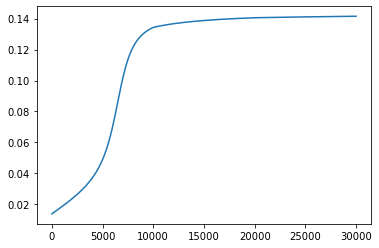

In [113]:
from matplotlib import pyplot as plt
plt.plot(sharpes)
plt.show()

In [114]:
np.max(sharpes)

0.141555375986325

In [115]:
weight_check(weights)

1.0000000000000002
0.9032334672226752 0.0009156538353771781


In [116]:
std_check(weights,returns) - nifty_standard_deviation

0.011038890473759345

## Gradient descent again !
#### But now we put the limits on the ratio of each being less 0.1, and softmax takes care of the other 2 conditions. 
##### As we talk about the standard deviation being less than nifty standard deviation , the intial weights have the standard deviation less than that of the nifty, hence the gradient going in the direction of increasing standard deviation by a lot is very unlikely,(Since the standrd deviation is in the denominator if our cost(reward) function). If the experimented result was not under the given standard deviation my plan was to add one more - standard deviation to sharpe to create a new rewarrd funtion

In [168]:
weights = np.zeros(50)# right now the ratios are 1/50 = 0.02, which is within the limits
learning_rate = 0.1 # roughly estimated it to be 1/100 of the intial weights
learnt_weights = np.zeros(50)
sds = []
sharpes = []
dw = 0.0001
# we go for 1000 iterations or if the derivative is small enough(but no way to )
for k in tqdm_notebook(range(100000)):
    for i in range(50):
        new_weights = np.array(weights)
        new_weights[i] = new_weights[i] + dw
        derivatives = (sharpe_ratio(new_weights,returns,daily_rfi) - sharpe_ratio(weights,returns,daily_rfi))/dw
        learnt_weights[i] = min(weights[i] + learning_rate*(derivatives), np.log(0.09995*np.sum(np.exp(learnt_weights))))
    sharpes.append(sharpe_ratio(learnt_weights,returns,daily_rfi))
    weights = np.array(learnt_weights)
    sds.append(std_check(weights,returns))
#     if k%10000 == 0 and k!= 0:
#         learning_rate = learning_rate/2

C:\Users\prakh\AppData\Local\Temp/ipykernel_7840/4009388255.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(100000)):


  0%|          | 0/100000 [00:00<?, ?it/s]

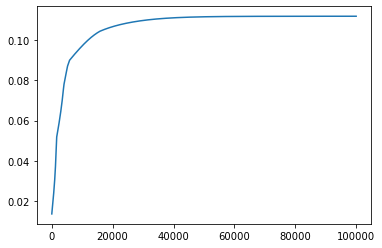

In [169]:
plt.plot(sharpes)
plt.show() 

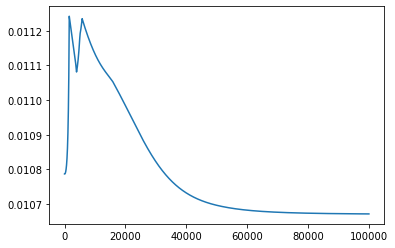

In [170]:
plt.plot(sds)
plt.show()

In [171]:
np.max(sharpes)

0.11173973836346991

In [172]:
weight_check(weights)

1.0
0.0999547547310976 0.001459684928494501


In [173]:
std_check(weights,returns) - nifty_standard_deviation

-0.00022181095919409852

### This marks the completion of the maximizing using gardient descent as well. for this learning rate the maximum sharpe value converges at sharpe ratio about .1114(still the derivatives were not 0). Maybe we can a better result with the little less learning and a lot more iterations (could converge the previous highest .125). 
# Maybe as we cannot get the weights are not allowed to go to 0 as the derivative as we are approaching the smaller values goes to goes to even smaller values.  
#### But we move on to checks standard deviation less than nifty, ratios less 0.1(max: 0.09995), greater than 0(min : 0.0014), , and sum as well 1

In [174]:
# we create a function to use derivatives
def sharpe_ratio(weights, returns, rfi):
    ratios = np.abs(weights)/np.sum(np.abs(weights))
    mean_returns = np.mean(returns, axis=1)
    excess_mean_returns = mean_returns - daily_rfi
    std_dev = np.sqrt(np.matmul(np.matmul(ratios,np.cov(returns)), ratios.T))
    return excess_mean_returns@ratios/std_dev
# We use the three condtions on the weights, checked here
def weight_check (weights):
    ratios = weights/np.sum(weights)
    sums = np.sum(ratios)
    print(sums)
    print(np.max(ratios), np.min(ratios))
# we can check the standard deviation condition here 
def std_check(weights, returns):
    ratios = weights/np.sum(weights)
    std_dev = np.sqrt(np.matmul(np.matmul(ratios,np.cov(returns)), ratios.T))
    return std_dev

In [ ]:
weights = 0.02*np.ones(50)# right now the ratios are 1/50 = 0.02, which is within the limits
learning_rate = 0.0009 # roughly estimated it to be 1/100 of the intial weights
learnt_weights = 0.02*np.ones(50)
sds = []
sharpes = []
dw = 0.00001
# we go for 1000 iterations or if the derivative is small enough(but no way to )
for k in tqdm_notebook(range(20000)):
    for i in range(50):
        new_weights = np.array(weights)
        new_weights[i] = new_weights[i] + dw
        derivatives = (sharpe_ratio(new_weights,returns,daily_rfi) - sharpe_ratio(weights,returns,daily_rfi))/dw
        learnt_weights[i] = min(weights[i] + learning_rate*(derivatives), 0.1*(np.sum(weights)))
        learnt_weights[i] = max(0.0000009,learnt_weights[i])
    sharpes.append(sharpe_ratio(learnt_weights,returns,daily_rfi))
    weights = np.array(learnt_weights)
    sds.append(std_check(weights,returns))

C:\Users\prakh\AppData\Local\Temp/ipykernel_7840/539076665.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(20000)):


  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
plt.plot(sharpes)
plt.show() 

In [ ]:
weight_check(weights)

In [183]:
np.max(sharpes)

0.016047938846581514

In [179]:
weights

array([1.19899582e-05, 9.00000000e-07, 9.00000000e-07, 9.00000000e-07,
       1.19899582e-05, 9.00000000e-07, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 9.00000000e-07, 1.19899582e-05, 9.00000000e-07,
       1.19899582e-05, 9.00000000e-07, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 9.00000000e-07, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 9.00000000e-07, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 1.19899582e-05, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 9.00000000e-07, 9.00000000e-07, 1.19899582e-05,
       9.00000000e-07, 1.19899582e-05, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 9.00000000e-07, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 9.00000000e-07, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 9.00000000e-07, 9.00000000e-07, 9.00000000e-07,
       9.00000000e-07, 9.00000000e-07])